#### Settings

In [1]:
from pathlib import Path

import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
string_pa = pd.ArrowDtype(pa.string())

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
pd.set_option('display.precision', 2)

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
data_file = Path.home() / 'python' / 'analysis' / 'ge_malaysia' / 'data-clean' / 'data-clean.csv'

df = (
    pd.read_csv(
        data_file,
        dtype_backend='pyarrow',
        engine='pyarrow'
    )
    .astype({
        'total_registered_voters': 'uint32[pyarrow]',
        'total_votes_cast': 'uint32[pyarrow]',
        'absent_voters': 'uint32[pyarrow]',
        'majority': 'uint32[pyarrow]',
    })
    .loc[:, ['election_term', 'state', 'seat_code', 'total_registered_voters', 'total_votes_cast', 'voter_turnout_percentage', 'absent_voters', 'majority']]
)

df

,election_term,state,seat_code,total_registered_voters,total_votes_cast,voter_turnout_percentage,absent_voters,majority
0,ge12,Perlis,P.001,36614,29310,0.8000,7304,5348
1,ge12,Perlis,P.002,43589,34946,0.8020,8643,13671
2,ge12,Perlis,P.003,39875,33276,0.8340,6599,300
3,ge12,Kedah,P.004,29568,23273,0.7870,6295,4970
4,ge12,Kedah,P.005,45511,37297,0.8200,8214,2205
...,...,...,...,...,...,...,...,...
875,ge15,Sarawak,P.218,58522,33916,0.5795,24606,11745
876,ge15,Sarawak,P.219,143229,78148,0.5456,65081,6159
877,ge15,Sarawak,P.220,59535,29783,0.5003,29752,7339
878,ge15,Sarawak,P.221,41999,19796,0.4713,22203,9998


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   election_term             880 non-null    string[pyarrow]
 1   state                     880 non-null    string[pyarrow]
 2   seat_code                 880 non-null    string[pyarrow]
 3   total_registered_voters   880 non-null    uint32[pyarrow]
 4   total_votes_cast          880 non-null    uint32[pyarrow]
 5   voter_turnout_percentage  880 non-null    double[pyarrow]
 6   absent_voters             880 non-null    uint32[pyarrow]
 7   majority                  880 non-null    uint32[pyarrow]
dtypes: double[pyarrow](1), string[pyarrow](3), uint32[pyarrow](4)
memory usage: 45.7 KB


In [4]:
df.describe()

,total_registered_voters,total_votes_cast,voter_turnout_percentage,absent_voters,majority
count,880.0000,880.0000,880.0000,880.0000,880.0000
mean,"68,321.7455","53,802.3057",0.7819,"14,519.4398","12,788.9511"
std,"35,664.0791","28,858.4721",0.0762,"9,038.2472","15,028.9825"
min,"6,608.0000","5,416.0000",0.4713,"1,192.0000",45.0000
25%,"43,668.2500","33,928.7500",0.7473,"8,505.2500","3,412.2500"
50%,"61,937.0000","48,749.5000",0.7910,"12,121.0000","7,746.0000"
75%,"84,817.5000","67,634.5000",0.8410,"17,143.5000","15,558.7500"
max,"303,430.0000","244,291.0000",0.9160,"65,081.0000","124,619.0000"


In [5]:
df_ge12 = df[df['election_term'] == 'ge12']
df_ge13 = df[df['election_term'] == 'ge13']
df_ge14 = df[df['election_term'] == 'ge14']
df_ge15 = df[df['election_term'] == 'ge15']

dfs = {
    'GE12': df_ge12,
    'GE13': df_ge13,
    'GE14': df_ge14,
    'GE15': df_ge15,
    'Overall': df
}

#### Data Exploration

In [ ]:
fig = px.histogram(
    df,
    x='majority',
    marginal='box',
    color='election_term',
    title='Distribution of Majority'
)
fig.update_layout(bargap=0.1)
fig.show()

In [ ]:
sns.heatmap(
    df.corr(numeric_only=True),
    cmap='Reds',
    annot=True
)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

#### Q1: How has voter turnout percentage changed across election terms by state?

In [ ]:
df_turnout = (
    df.groupby('election_term')
    .agg(
        total_votes_cast = ('total_votes_cast', 'sum'),
        total_registered_voters = ('total_registered_voters', 'sum'),
    )
    .assign(
        overall_voter_turnout_percentage = lambda x: (x['total_votes_cast'] / x['total_registered_voters'])
    )
    #.loc[:, 'overall_voter_turnout_percentage']
)

df_turnout

In [ ]:
df_turnout = (
    pd.pivot_table(
        df,
        index='state',
        columns='election_term',
        aggfunc={
            'total_votes_cast': 'sum',
            'total_registered_voters': 'sum'
        }
    )
)

df_turnout

In [ ]:
turnout_percentage = pd.DataFrame()

election_terms = df_turnout['total_votes_cast'].columns

for term in election_terms:
    turnout_percentage[term] = (
        (df_turnout['total_votes_cast'][term] / df_turnout['total_registered_voters'][term]).mul(100)
    )

(
    turnout_percentage
    .style
    .format({
        'ge12': "{:.1f}%",
        'ge13': "{:.1f}%",
        'ge14': "{:.1f}%",
        'ge15': "{:.1f}%",
    })
    .background_gradient(cmap='coolwarm', axis=0)
)

#### Q2: What is the relationship between absent voters and majority margins across election terms?

In [ ]:
fig = px.scatter(
    df,
    x='majority',
    y='absent_voters',
    color='election_term',
    opacity=0.8,
    hover_data=['state'],
)
fig.update_traces(marker_size=5)
fig.show()

In [ ]:
print("Correlation between Majority and Absentee")

for election, df in dfs.items():
    correlation = df['majority'].corr(df['absent_voters'])
    print(f"{election}: {correlation: .4}")

#### Q3: Can we predict voter turnout percentage based on total registered voters and state?

In [9]:
from sklearn.model_selection import train_test_split

# Exclude W.P.
df = df[~df['state'].str.contains('W.P.')].copy()

# Select features and target
X = df[['total_registered_voters', 'state']]
y = df['voter_turnout_percentage']

data = pd.concat([X, y], axis=1).dropna()
X = data[['total_registered_voters', 'state']]
y = data['voter_turnout_percentage']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 662 rows
Testing set size: 166 rows


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['total_registered_voters']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['state'])
    ]
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Check coefficients
coef_names = (['total_registered_voters'] + 
              model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist())
coefficients = model.named_steps['regressor'].coef_
print("Feature Coefficients:")
for name, coef in zip(coef_names, coefficients):
    print(f"{name}: {coef:.4f}")
print("Intercept:", model.named_steps['regressor'].intercept_)

Feature Coefficients:
total_registered_voters: -0.0141
state_Kedah: 0.0148
state_Kelantan: -0.0044
state_Melaka: 0.0245
state_Negeri Sembilan: -0.0023
state_Pahang: -0.0044
state_Perak: -0.0247
state_Perlis: -0.0176
state_Pulau Pinang: 0.0111
state_Sabah: -0.0826
state_Sarawak: -0.1289
state_Selangor: 0.0400
state_Terengganu: 0.0503
Intercept: 0.8056529559659782


In [11]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Compare predicted vs actual (first 5 rows)
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head()
comparison

R² Score: 0.414
RMSE: 0.061


,Actual,Predicted
647,0.7780,0.6743
483,0.8050,0.8140
303,0.8420,0.8076
596,0.8290,0.7911
181,0.6530,0.7369


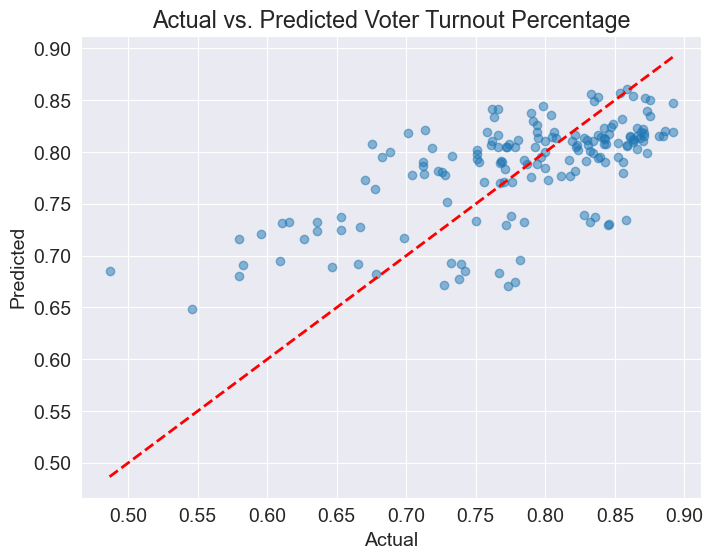

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Voter Turnout Percentage')
plt.show()

In [18]:
# Assume GE15 is the target term to predict
historical_terms = ['ge12', 'ge13', 'ge14']
target_term = 'ge15'

# Exclude W.P.
df = df[~df['state'].str.contains('W.P.')].copy()

# Historical data (past terms)
df_historical = df[df['election_term'].isin(historical_terms)].copy()

# Calculate historical data
historical_turnout = df_historical.groupby('state')['voter_turnout_percentage'].mean().reset_index()
historical_turnout.columns = ['state', 'historical_turnout']

# Target data (GE15)
df_target = df[df['election_term'] == target_term].copy()

# Merge historical turnout into the target dataset
df_target = df_target.merge(historical_turnout, on='state', how='left')

# Select features and target
X = df_target[['total_registered_voters', 'state', 'historical_turnout']]
y = df_target['voter_turnout_percentage']

# Drop rows with missing values
data = pd.concat([X, y], axis=1).dropna()
X = data[['total_registered_voters', 'state', 'historical_turnout']]
y = data['voter_turnout_percentage']

In [19]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 167 rows
Testing set size: 42 rows


In [20]:
# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['total_registered_voters', 'historical_turnout']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['state'])
    ]
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Check coefficients
coef_names = (['total_registered_voters', 'historical_turnout'] + 
              model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist())
coefficients = model.named_steps['regressor'].coef_
print("Feature Coefficients:")
for name, coef in zip(coef_names, coefficients):
    print(f"{name}: {coef:.4f}")
print("Intercept:", model.named_steps['regressor'].intercept_)

Feature Coefficients:
total_registered_voters: -0.0042
historical_turnout: 0.0532
state_Kedah: 0.0103
state_Kelantan: -0.0479
state_Melaka: 0.0230
state_Negeri Sembilan: 0.0350
state_Pahang: 0.0355
state_Perak: 0.0360
state_Perlis: -0.0514
state_Pulau Pinang: 0.0087
state_Sabah: -0.0446
state_Sarawak: -0.0064
state_Selangor: 0.0418
state_Terengganu: 0.0079
Intercept: 0.7222628497759452


In [21]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Compare predicted vs actual
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head()
comparison

R² Score: 0.649
RMSE: 0.052


,Actual,Predicted
30,0.7005,0.7043
171,0.6157,0.6316
84,0.7903,0.7667
198,0.6228,0.6064
60,0.7819,0.7478


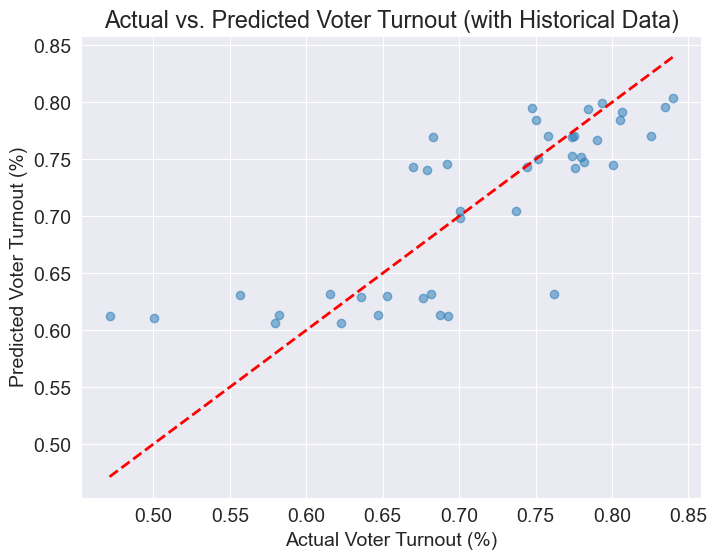

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Voter Turnout (%)')
plt.ylabel('Predicted Voter Turnout (%)')
plt.title('Actual vs. Predicted Voter Turnout (with Historical Data)')
plt.show()